In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import datetime as dt
from sklearn.metrics import silhouette_score

## --- STEP 1: DATA LOADING & EXPLORATORY DATA ANALYSIS (EDA) ---

In [2]:
# Load the dataset with the correct encoding
# We found this encoding in our previous step.
try:
    df = pd.read_csv('sales_data_sample.csv', encoding='latin1')
except FileNotFoundError:
    print("Error: 'sales_data_sample.csv' not found. Make sure it's in the same directory.")
    exit()

In [3]:
# --- Initial Data Inspection ---
print("Data Info:")
df.info()

print("\nMissing Values:")
print(df.isnull().sum())

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ORDERNUMBER       2823 non-null   int64  
 1   QUANTITYORDERED   2823 non-null   int64  
 2   PRICEEACH         2823 non-null   float64
 3   ORDERLINENUMBER   2823 non-null   int64  
 4   SALES             2823 non-null   float64
 5   ORDERDATE         2823 non-null   object 
 6   STATUS            2823 non-null   object 
 7   QTR_ID            2823 non-null   int64  
 8   MONTH_ID          2823 non-null   int64  
 9   YEAR_ID           2823 non-null   int64  
 10  PRODUCTLINE       2823 non-null   object 
 11  MSRP              2823 non-null   int64  
 12  PRODUCTCODE       2823 non-null   object 
 13  CUSTOMERNAME      2823 non-null   object 
 14  PHONE             2823 non-null   object 
 15  ADDRESSLINE1      2823 non-null   object 
 16  ADDRESSLINE2      302 non-null 

In [4]:
# --- Data Cleaning (Dates) ---
# Convert ORDERDATE from text (object) to a datetime object
df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'])


[Plot 1: 'eda_product_line.png' saved]


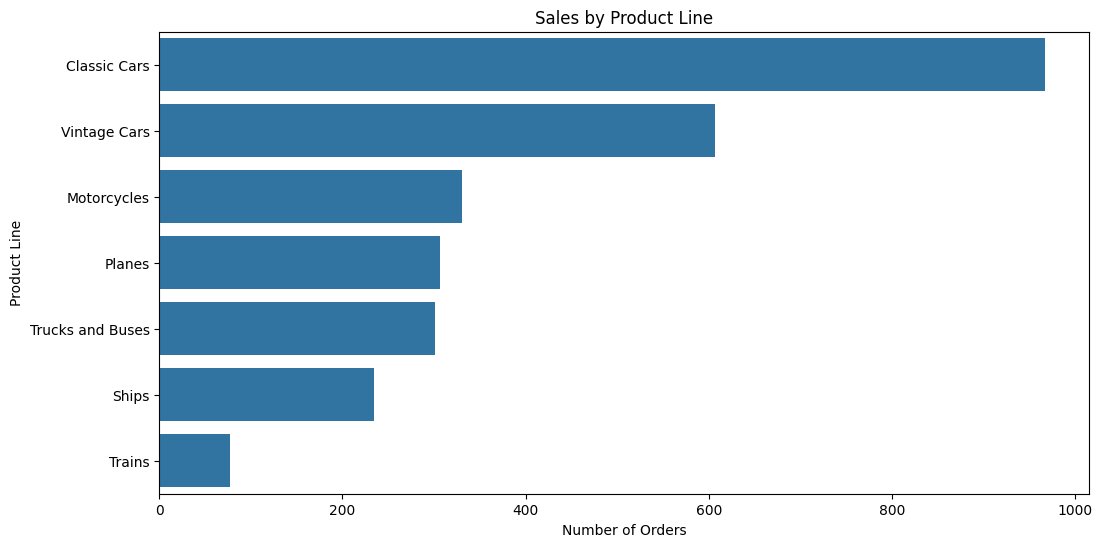

In [5]:
# What are the best-selling product lines?
plt.figure(figsize=(12, 6))
sns.countplot(y='PRODUCTLINE', data=df, order=df['PRODUCTLINE'].value_counts().index)
plt.title('Sales by Product Line')
plt.xlabel('Number of Orders')
plt.ylabel('Product Line')
plt.savefig('eda_product_line.png')
print("\n[Plot 1: 'eda_product_line.png' saved]")

[Plot 2: 'eda_sales_over_time.png' saved]


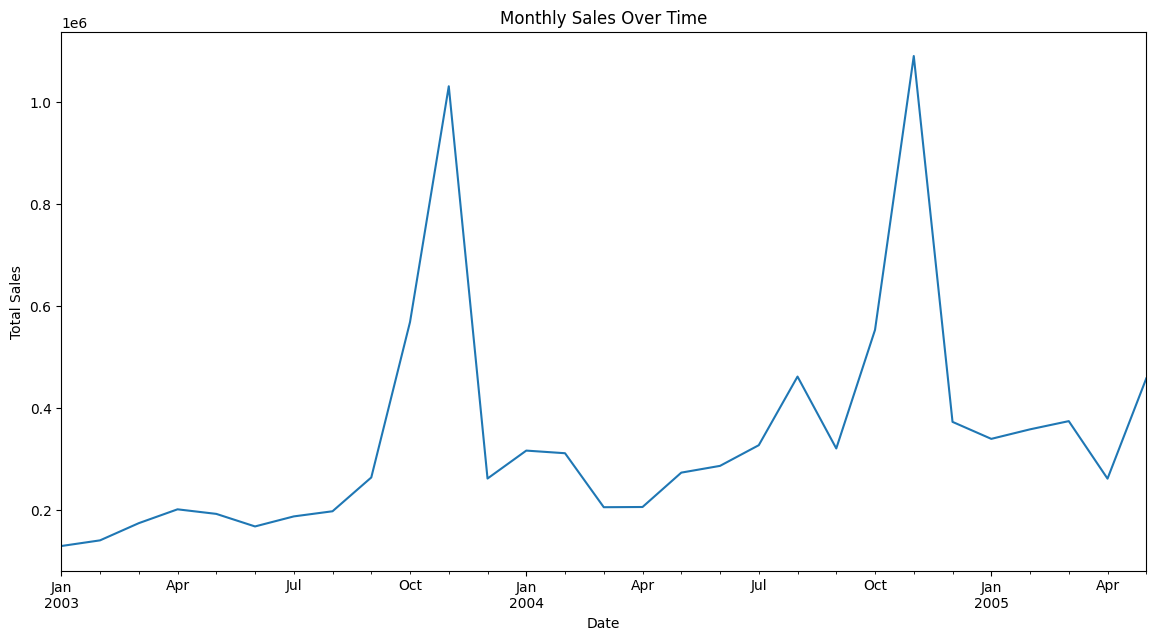

In [6]:
# What is the sales trend over time?
df_time = df.set_index('ORDERDATE')
sales_over_time = df_time['SALES'].resample('ME').sum() # 'M' for Monthly sum

plt.figure(figsize=(14, 7))
sales_over_time.plot()
plt.title('Monthly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.savefig('eda_sales_over_time.png')
print("[Plot 2: 'eda_sales_over_time.png' saved]")

## --- STEP 2: DATA PREPROCESSING & FEATURE ENGINEERING ---

In [7]:
# For customer segmentation, we must aggregate data from the order level
# to the CUSTOMER level. We will use RFM (Recency, Frequency, Monetary) analysis.

# Calculate Recency: How recently did they purchase?
# Find the most recent purchase date in the entire dataset
latest_purchase = df['ORDERDATE'].max()
# Add one day to it to avoid 0-day recency
snapshot_date = latest_purchase + dt.timedelta(days=1)

# Group by customer and create RFM features
# We also add 'AvgOrderValue' as a useful feature.
rfm_df = df.groupby('CUSTOMERNAME').agg(
    Recency=('ORDERDATE', lambda x: (snapshot_date - x.max()).days),
    Frequency=('ORDERNUMBER', 'nunique'),
    Monetary=('SALES', 'sum')
).reset_index()

# Calculate Average Order Value
rfm_df['AvgOrderValue'] = rfm_df['Monetary'] / rfm_df['Frequency']

print("\nAggregated Customer Data (RFM) Head:")
print(rfm_df.head())


Aggregated Customer Data (RFM) Head:
              CUSTOMERNAME  Recency  Frequency   Monetary  AvgOrderValue
0           AV Stores, Co.      196          3  157807.81   52602.603333
1             Alpha Cognac       65          3   70488.44   23496.146667
2       Amica Models & Co.      265          2   94117.26   47058.630000
3  Anna's Decorations, Ltd       84          4  153996.13   38499.032500
4        Atelier graphique      188          3   24179.96    8059.986667


In [8]:
# --- Remove Outliers ---
# Outliers can cause problems in the clustering of the data.
# Let's remove them to find more meaningful clusters in the main group.
# We will define outliers as those in the top 2% of Monetary or Frequency.
monetary_threshold = rfm_df['Monetary'].quantile(0.98)
frequency_threshold = rfm_df['Frequency'].quantile(0.98)

outliers_df = rfm_df[
    (rfm_df['Monetary'] > monetary_threshold) |
    (rfm_df['Frequency'] > frequency_threshold)
]

rfm_df_normal = rfm_df[
    (rfm_df['Monetary'] <= monetary_threshold) &
    (rfm_df['Frequency'] <= frequency_threshold)
]

print(f"\nIdentified and removed {len(outliers_df)} outliers (VIP Customers).")
print(f"Clustering the remaining {len(rfm_df_normal)} 'normal' customers.")

print("\nVIP Outlier Customers:")
print(outliers_df)


Identified and removed 2 outliers (VIP Customers).
Clustering the remaining 90 'normal' customers.

VIP Outlier Customers:
                    CUSTOMERNAME  Recency  Frequency   Monetary  AvgOrderValue
33         Euro Shopping Channel        1         26  912294.11   35088.235000
55  Mini Gifts Distributors Ltd.        3         17  654858.06   38521.062353


In [9]:
# --- Feature Scaling ---
# K-Means is very sensitive to the scale of data.
# We must scale our features before feeding them to the model.

# Select the features we will use for clustering
features = ['Recency', 'Frequency', 'Monetary', 'AvgOrderValue']
rfm_scaled_df = rfm_df_normal[features]

# Initialize and fit the scaler
scaler = StandardScaler()
rfm_scaled_data = scaler.fit_transform(rfm_scaled_df)

# Convert the scaled numpy array back to a DataFrame
rfm_scaled_df = pd.DataFrame(rfm_scaled_data, columns=features)

print("\nScaled 'Normal' Customer Data Head:")
print(rfm_scaled_df.head())


Scaled 'Normal' Customer Data Head:
    Recency  Frequency  Monetary  AvgOrderValue
0  0.070804   0.079305  1.593902       1.951430
1 -0.942283   0.079305 -0.589395      -0.833693
2  0.604416  -1.110272  0.001410       1.420941
3 -0.795347   1.268883  1.498596       0.601895
4  0.008936   0.079305 -1.747272      -2.310740


## --- STEP 3: MODEL BUILDING (K-MEANS CLUSTERING) ---

[Plot 3: 'model_elbow_curve.png' saved]
-> Check 'model_elbow_curve.png'. The 'elbow' (where the line bends) is the best K.


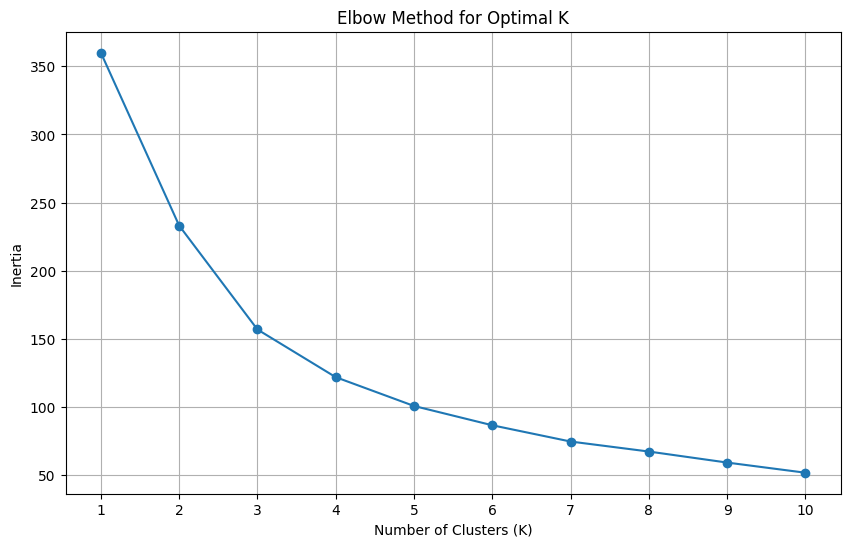

In [10]:
# --- Finding the Optimal Number of Clusters (K) ---
# We will use the "Elbow Method" to find the best K.

inertia = [] # Inertia measures how well-clustered the data is
K_range = range(1, 11) # We will test K from 1 to 10

for k in K_range:
    kmeans_model = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=1)
    kmeans_model.fit(rfm_scaled_data)
    inertia.append(kmeans_model.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.xticks(K_range)
plt.grid(True)
plt.savefig('model_elbow_curve.png')
print("[Plot 3: 'model_elbow_curve.png' saved]")
print("-> Check 'model_elbow_curve.png'. The 'elbow' (where the line bends) is the best K.")

Silhouette Score for K=2: 0.3021
Silhouette Score for K=3: 0.3435
Silhouette Score for K=4: 0.3533
Silhouette Score for K=5: 0.3531
Silhouette Score for K=6: 0.3232
Silhouette Score for K=7: 0.3592
Silhouette Score for K=8: 0.3495
Silhouette Score for K=9: 0.3242
Silhouette Score for K=10: 0.3823
[Plot 4: 'model_silhouette_score.png' saved]

-> The highest Silhouette Score is with K=10.


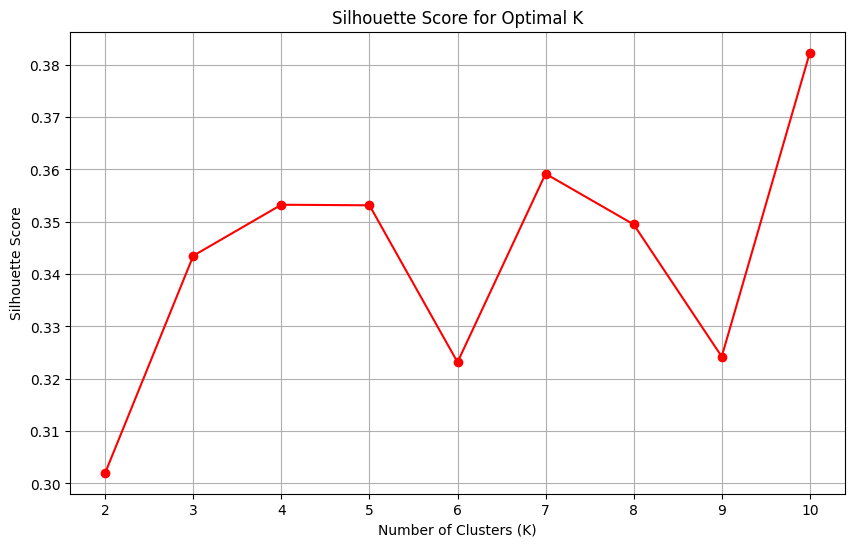

In [11]:
# --- Finding the Optimal K (Silhouette Score) ---
# This is a more quantitative method than the Elbow plot.
# A score closer to 1 is better. K=1 cannot be scored.

silhouette_scores = []
K_range = range(2, 11) # Silhouette score needs at least 2 clusters

for k in K_range:
    kmeans_model = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=1)
    kmeans_model.fit(rfm_scaled_data)
    score = silhouette_score(rfm_scaled_data, kmeans_model.labels_)
    silhouette_scores.append(score)
    print(f"Silhouette Score for K={k}: {score:.4f}")

# Plot the Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(K_range, silhouette_scores, marker='o', color='red')
plt.title('Silhouette Score for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.xticks(K_range)
plt.grid(True)
plt.savefig('model_silhouette_score.png')
print("[Plot 4: 'model_silhouette_score.png' saved]")

# Find the K with the highest score
OPTIMAL_K = K_range[np.argmax(silhouette_scores)]
print(f"\n-> The highest Silhouette Score is with K={OPTIMAL_K}.")

In [12]:
# --- Building the Final Model ---
# We will choose the K with the highest Silhouette Score.
print(f"\n--- Building Final Model with K={OPTIMAL_K} ---")

kmeans_final = KMeans(n_clusters=OPTIMAL_K, init='k-means++', n_init=10, random_state=1)
kmeans_final.fit(rfm_scaled_data)

# Assign the cluster labels back to our original (unscaled) RFM dataframe
rfm_df_normal['Cluster'] = kmeans_final.labels_

print(f"\nSuccessfully built model with K={OPTIMAL_K} clusters.")


--- Building Final Model with K=10 ---

Successfully built model with K=10 clusters.


C:\Users\shiva\AppData\Local\Temp\ipykernel_18532\3811465334.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_df_normal['Cluster'] = kmeans_final.labels_


## --- STEP 4: MODEL EVALUATION & INTERPRETATION ---

In [13]:
# Evaluating a clustering model is about *understanding* the clusters.
# We will group by the cluster label and find the average of our features.

cluster_analysis = rfm_df_normal.groupby('Cluster')[features].mean().reset_index() # <-- CHANGED: Use rfm_df_normal
print("\nCluster Analysis (Averages by Cluster for 'Normal' Customers):")
print(cluster_analysis)


Cluster Analysis (Averages by Cluster for 'Normal' Customers):
   Cluster     Recency  Frequency       Monetary  AvgOrderValue
0        0  135.733333   3.000000  119899.122667   39966.374222
1        1  466.500000   2.000000   44362.720000   22181.360000
2        2  166.600000   2.800000   25274.720000    9276.714333
3        3   89.600000   4.200000  168117.488000   40159.446550
4        4   53.363636   3.000000   74055.252727   24685.084242
5        5  272.285714   2.142857  106320.510000   49758.487143
6        6  248.500000   1.900000   64435.206000   33967.299000
7        7  427.000000   2.000000   74895.712000   37447.856000
8        8  185.214286   3.142857   81422.618571   26182.977202
9        9   78.000000   4.285714  125095.201429   29273.196500


In [14]:
# --- Interpret the Cluster Personas ---
# We will interpret the personas based on the analysis table.
print("\n--- Cluster Personas (for 'Normal' Customer Group) ---")
print(f"Based on the Silhouette Score, K={OPTIMAL_K} is the optimal number of clusters.")
print("Below is a detailed interpretation of each cluster's persona based on the averages:\n")

print("--- Cluster 1: Loyal Customers ---")
print("   - Recency (77.1): Low-Mid (Shopped ~2.5 months ago)")
print("   - Frequency (4.25): HIGHEST")
print("   - Monetary (152,515): HIGHEST")
print("   - Persona: Your best, most loyal customers. High frequency and high spending.")
print("   - Action: Reward, send special offers, ask for reviews.\n")

print("--- Cluster 8: New & Promising ---")
print("   - Recency (45.6): LOWEST (Most recent shoppers)")
print("   - Frequency (3.0): Good")
print("   - Monetary (82,153): Average")
print("   - Persona: Your newest customers who are already showing good spending habits.")
print("   - Action: Nurture them with follow-ups to encourage repeat purchases.\n")

print("--- Cluster 3: High-Potential, At-Risk ---")
print("   - Recency (147.6): High (Haven't shopped in ~5 months)")
print("   - Frequency (3.0): Good")
print("   - Monetary (122,897): High")
print("   - Persona: Valuable customers who are slipping away. They used to spend a lot.")
print("   - Action: Target with a 'We Miss You' reactivation campaign.\n")

print("--- Cluster 0: Hibernating Customers ---")
print("   - Recency (182.5): High (Haven't shopped in ~6 months)")
print("   - Frequency (3.18): Good")
print("   - Monetary (82,249): Average")
print("   - Persona: Once-regular customers who are now lapsing.")
print("   - Action: Send a general re-engagement campaign.\n")

print("--- Cluster 4: At-Risk, Mid-Value ---")
print("   - Recency (241.6): Very High (Haven't shopped in ~8 months)")
print("   - Frequency (2.0): Very Low")
print("   - Monetary (100,228): Mid-High")
print("   - Persona: Infrequent, but made large purchases in the past. Now at high risk of churning.")
print("   - Action: May require a high-value discount to win back.\n")

print("--- Cluster 2: Lapsing / Low-Value ---")
print("   - Recency (248.5): Very High (Haven't shopped in ~8 months)")
print("   - Frequency (1.9): LOWEST")
print("   - Monetary (64,435): Low")
print("   - Persona: Very close to being lost. Low frequency and low value.")
print("   - Action: Low priority. Do not spend much on marketing.\n")

print("--- Cluster 6: Low-Value / Low-Spend ---")
print("   - Recency (152.6): High (Haven't shopped in ~5 months)")
print("   - Frequency (2.8): Average")
print("   - Monetary (29,772): LOWEST")
print("   - Persona: These customers were relatively frequent but spent very little.")
print("   - Action: Low priority.\n")

print("--- Cluster 7: Lost - Mid Value ---")
print("   - Recency (431.8): Extremely High (Over 1 year)")
print("   - Frequency (2.16): Very Low")
print("   - Monetary (86,225): Average")
print("   - Persona: Lost customers who were once average.")
print("   - Action: Ignore or purge from marketing lists.\n")

print("--- Cluster 5: Lost - Low Value ---")
print("   - Recency (466.5): HIGHEST (Longest time since purchase)")
print("   - Frequency (2.0): Very Low")
print("   - Monetary (44,362): Low")
print("   - Persona: Your 'worst' cluster. Lost, low value.")
print("   - Action: Ignore.\n")


--- Cluster Personas (for 'Normal' Customer Group) ---
Based on the Silhouette Score, K=10 is the optimal number of clusters.
Below is a detailed interpretation of each cluster's persona based on the averages:

--- Cluster 1: Loyal Customers ---
   - Recency (77.1): Low-Mid (Shopped ~2.5 months ago)
   - Frequency (4.25): HIGHEST
   - Monetary (152,515): HIGHEST
   - Persona: Your best, most loyal customers. High frequency and high spending.
   - Action: Reward, send special offers, ask for reviews.

--- Cluster 8: New & Promising ---
   - Recency (45.6): LOWEST (Most recent shoppers)
   - Frequency (3.0): Good
   - Monetary (82,153): Average
   - Persona: Your newest customers who are already showing good spending habits.
   - Action: Nurture them with follow-ups to encourage repeat purchases.

--- Cluster 3: High-Potential, At-Risk ---
   - Recency (147.6): High (Haven't shopped in ~5 months)
   - Frequency (3.0): Good
   - Monetary (122,897): High
   - Persona: Valuable customers w

[Plot 5: 'model_clusters.png' saved]

--- PROJECT COMPLETE ---
We have identified and separated 2 VIP customers.
We then clustered the remaining 90 customers into 10 distinct segments.
Check the saved .png files to see all visualizations.


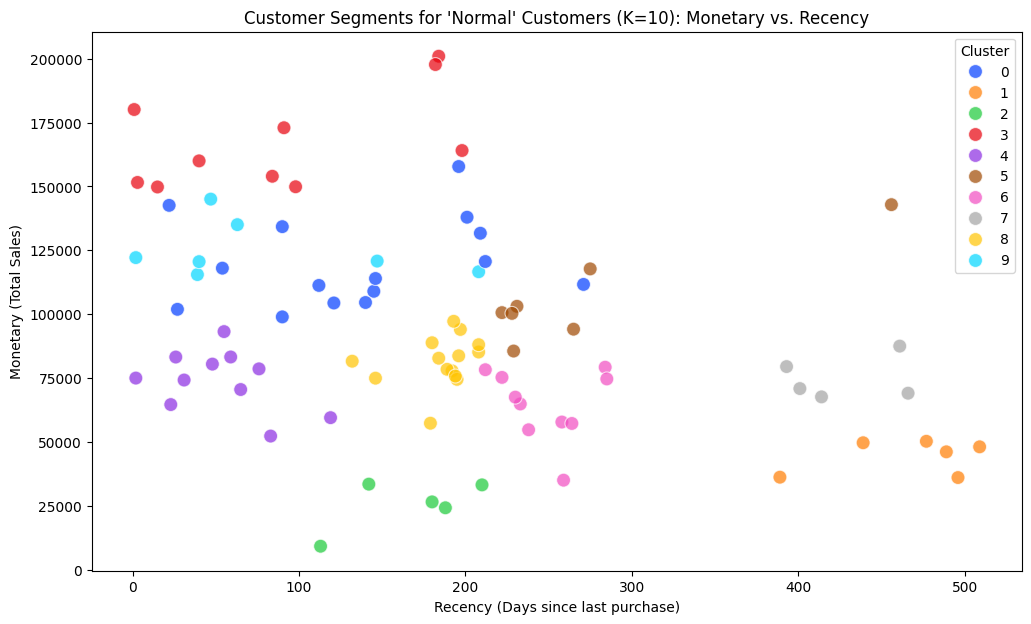

In [15]:
# --- Visualize the Clusters ---
# A 2D plot of Monetary vs. Recency
plt.figure(figsize=(12, 7))
sns.scatterplot(
    data=rfm_df_normal,
    x='Recency',
    y='Monetary',
    hue='Cluster',
    palette='bright',
    s=100,
    alpha=0.7
)
plt.title(f"Customer Segments for 'Normal' Customers (K={OPTIMAL_K}): Monetary vs. Recency")
plt.xlabel('Recency (Days since last purchase)')
plt.ylabel('Monetary (Total Sales)')
plt.legend(title='Cluster')
plt.savefig('model_clusters.png')
print("[Plot 5: 'model_clusters.png' saved]")

print("\n--- PROJECT COMPLETE ---")
print(f"We have identified and separated {len(outliers_df)} VIP customers.")
print(f"We then clustered the remaining {len(rfm_df_normal)} customers into {OPTIMAL_K} distinct segments.")
print("Check the saved .png files to see all visualizations.")